In [16]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from keras import layers
import os

In [17]:
# 1) CARREGANDO A PLANILHA
df = pd.read_excel('C:/Users/Meu Computador/Documents/Tubaroes/SP_Reconstrucao_Siluriformes_2024_12_16.xlsx')

pasta_pesos = r'C:/Users/Meu Computador/Documents/Tubaroes/pesos_prop_Bagre_art2'
os.makedirs(pasta_pesos, exist_ok=True)

# 2) SELECIONANDO COLUNAS DE INTERESSE
#    Temos 4 subespécies (Bagre_amarelo_art, Bagre_branco_art, Parare_art, Bagre_bandeira_art)
#    e a coluna agregadora "Bagre_art".
df_bagre = df[['Ano',
               'Bagre_amarelo_art',
               'Bagre_branco_art',
               'Parare_art',
               'Bagre_bandeira_art',
               'Bagre_art']]

# 3) DEFININDO OS ANOS QUE PRECISAMOS DESAGREGAR
#    Para o intervalo 1959 – 2022
anos_para_prever = np.arange(1959, 2023)

# 4) CORRIGINDO VALORES DE 'Bagre_art' CASO EXISTA ALGUM ANO
#    EM QUE 'Bagre_art' ESTEJA VAZIO, MAS TENHA VALORES NAS SUBESPÉCIES.
for i in range(len(df_bagre)):
    # Se Bagre_art estiver vazio, mas as subespécies não:
    if (
        pd.isnull(df_bagre.loc[i,'Bagre_art']) and
        not pd.isnull(df_bagre.loc[i,'Bagre_amarelo_art']) and
        not pd.isnull(df_bagre.loc[i,'Bagre_branco_art']) and
        not pd.isnull(df_bagre.loc[i,'Parare_art']) and
        not pd.isnull(df_bagre.loc[i,'Bagre_bandeira_art'])
    ):
        soma_sub = (df_bagre.loc[i,'Bagre_amarelo_art'] +
                    df_bagre.loc[i,'Bagre_branco_art'] +
                    df_bagre.loc[i,'Parare_art'] +
                    df_bagre.loc[i,'Bagre_bandeira_art'])
        df_bagre.loc[i,'Bagre_art'] = soma_sub

# 5) FILTRANDO OS DADOS QUE TÊM REGISTROS VÁLIDOS (sem NaN) E REINDEXANDO
df_bagre = df_bagre.dropna(subset=[
    'Bagre_amarelo_art',
    'Bagre_branco_art',
    'Parare_art',
    'Bagre_bandeira_art',
    'Bagre_art'
]).reset_index(drop=True)

# 6) CRIANDO UMA COLUNA COM A SOMA DAS SUBESPÉCIES
#    No código original, chamávamos de "Soma" (equivalente a Bagre_art).
df_bagre['Soma'] = (
    df_bagre['Bagre_amarelo_art'] +
    df_bagre['Bagre_branco_art'] +
    df_bagre['Parare_art'] +
    df_bagre['Bagre_bandeira_art']
)

# 7) SEPARANDO AS SUBESPÉCIES PARA FAZER A PROPORÇÃO
especies = ['Bagre_amarelo_art',
            'Bagre_branco_art',
            'Parare_art',
            'Bagre_bandeira_art']

# 8) CALCULANDO AS PROPORÇÕES DE CADA SUBESPÉCIE EM RELAÇÃO À SOMA
lista_de_prop = []
for esp in especies:
    dados = df_bagre[['Ano', esp, 'Soma']].copy()
    dados[f'Prop_{esp}'] = dados[esp] / dados['Soma']
    
    lista_de_prop.append(dados[f'Prop_{esp}'].values)
    
    print(f"\nEspécie: {esp}")
    print(dados.head())  # Exibe as 5 primeiras linhas


Espécie: Bagre_amarelo_art
    Ano  Bagre_amarelo_art      Soma  Prop_Bagre_amarelo_art
0  2010             1.6140  210.0904                0.007682
1  2011             2.7013  285.5480                0.009460
2  2012             4.4553  467.5131                0.009530
3  2013             5.6530  335.0208                0.016874
4  2014             4.9135  320.7329                0.015320

Espécie: Bagre_branco_art
    Ano  Bagre_branco_art      Soma  Prop_Bagre_branco_art
0  2010          199.1452  210.0904               0.947902
1  2011          269.2474  285.5480               0.942915
2  2012          435.2046  467.5131               0.930893
3  2013          312.2271  335.0208               0.931963
4  2014          296.2629  320.7329               0.923706

Espécie: Parare_art
    Ano  Parare_art      Soma  Prop_Parare_art
0  2010      0.3390  210.0904         0.001614
1  2011      0.8408  285.5480         0.002945
2  2012      1.2182  467.5131         0.002606
3  2013      1.0

In [19]:
# NORMALIZAÇÃO DOS ANOS
ano_mean = np.mean(anos_com_dados)
ano_std = np.std(anos_com_dados)

anos_para_prever_norm = (anos_para_prever - ano_mean) / ano_std
anos_com_dados_norm   = (anos_com_dados  - ano_mean) / ano_std

# NORMALIZAÇÃO DAS PROPORÇÕES
lista_prop_norm = []
lista_prop_mean = []
lista_prop_std  = []

for prop in lista_de_prop:
    prop_mean = np.mean(prop)
    prop_std  = np.std(prop)
    
    if prop_std == 0:
        prop_std = 1e-9
    
    prop_norm = (prop - prop_mean) / prop_std
    lista_prop_norm.append(prop_norm)
    lista_prop_mean.append(prop_mean)
    lista_prop_std.append(prop_std)



print(lista_prop_norm)

[array([-0.88630823, -0.83150157, -0.8293517 , -0.60293532, -0.650846  ,
       -0.79134149, -0.67697405, -0.35727978,  0.15818248,  1.6235039 ,
        2.18272252,  0.95260066,  0.70952858]), array([ 0.84140329,  0.74749057,  0.52113545,  0.54129123,  0.38581645,
        1.09641476,  0.99663931,  0.58823235, -0.23340714, -1.64041932,
       -2.00859067, -0.99888155, -0.83712474]), array([-1.16709288, -0.18263143, -0.43324456, -0.10088125,  2.43723898,
        1.43967494, -0.70948174, -0.993393  , -0.37139468, -0.35044958,
        0.8852668 ,  0.38815044, -0.84176204]), array([-0.65033215, -0.56524134, -0.00869859, -0.41005017, -0.12116024,
       -1.56265892, -1.35911544, -0.82909104,  0.351734  ,  1.58207026,
        1.57052178,  0.97937142,  1.02265043])]


In [10]:
def Fit_das_proporcoes(anos_norm,
                       lista_prop_norm,
                       lista_de_epocas,
                       lista_de_otimizadores,
                       lista_de_overwrite,
                       especies):
    
    model = keras.Sequential([
        layers.Dense(96, activation='leaky_relu', input_shape=(1,)),
        layers.Dense(32, activation='leaky_relu'),
        layers.Dense(80, activation='leaky_relu'),
        layers.Dense(80, activation='leaky_relu'),
        layers.Dense(96, activation='leaky_relu'),
        layers.Dense(112, activation='leaky_relu'),
        layers.Dense(1, activation='linear')
    ])
    
    lista_de_loss = []
    
    for k, esp in enumerate(especies):
        opt = lista_de_otimizadores[k]
        model.compile(optimizer=opt, loss='mse')
        
        history = model.fit(
            anos_norm,
            lista_prop_norm[k],
            epochs=lista_de_epocas[k],
            verbose=0
        )
        lista_de_loss.append(history.history['loss'])
        
        # Salvando pesos (mantendo mesma estrutura)
        model.save_weights(os.path.join(pasta_pesos, '.weights.h5'), overwrite=True)
    
    return model, lista_de_loss

In [11]:
# CHAMANDO A FUNÇÃO PARA FAZER O FIT DO MODELO
Adam  = keras.optimizers.Nadam(learning_rate=0.001)
Nadam = keras.optimizers.Adam(learning_rate=0.001)

# Agora temos 4 espécies, mas para manter a *mesma estrutura*, 
# ajustamos listas com 4 itens (cada subespécie).
lista_de_epocas      = [100, 100, 100, 100]
lista_de_otimizadores= [Nadam, Nadam, Nadam, Nadam]
lista_de_overwrite   = [True, True, True, True]

model, lista_de_loss = Fit_das_proporcoes(
    anos_com_dados_norm,
    lista_prop_norm,
    lista_de_epocas,
    lista_de_otimizadores,
    lista_de_overwrite,
    especies
)

In [12]:
# PREVISÕES PARA CADA ESPÉCIE
lista_de_previsoes = []
lista_fits = []

p = np.linspace(-2, 2, 50)

# Exatamente a mesma estrutura do código anterior, mas para as 4 subespécies
for k, esp in enumerate(especies):
    # Carregando pesos
    model.load_weights(f'C:/Users/Meu Computador/Documents/Tubaroes/pesos_prop_Bagre_art/.weights.h5')
    
    # Previsões para anos ausentes
    prev_ausentes = model.predict(anos_para_prever_norm)
    prev_ausentes = prev_ausentes * lista_prop_std[k] + lista_prop_mean[k]
    
    fit_valores = model.predict(p)
    fit_valores = fit_valores * lista_prop_std[k] + lista_prop_mean[k]
    
    # Ajustando valores para que fiquem entre 0 e 1
    prev_ausentes[prev_ausentes < 0] = 0
    prev_ausentes[prev_ausentes > 1] = 1
    
    lista_de_previsoes.append(prev_ausentes)
    lista_fits.append(fit_valores)

2/2 [==============================] - 0s 1ms/step


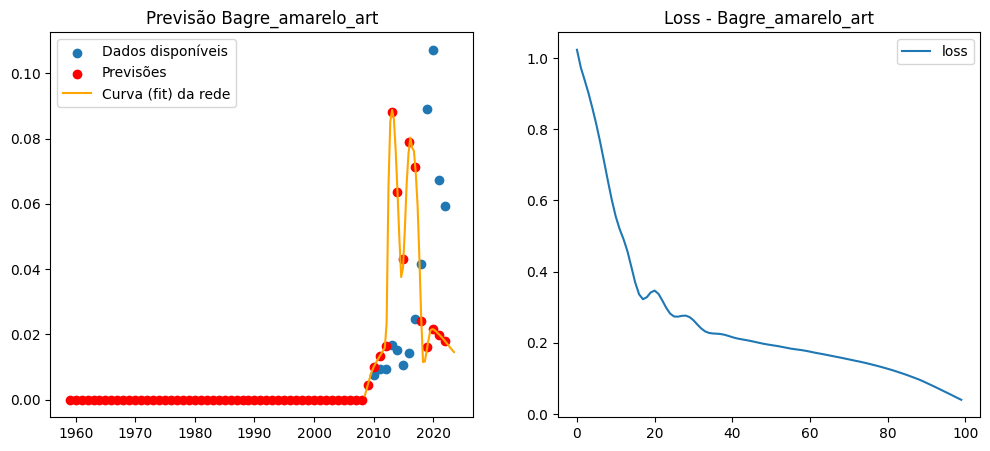

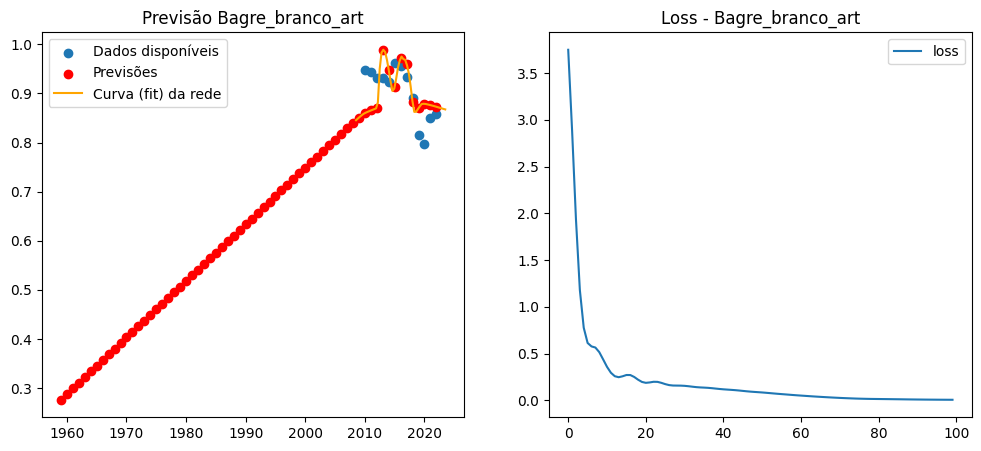

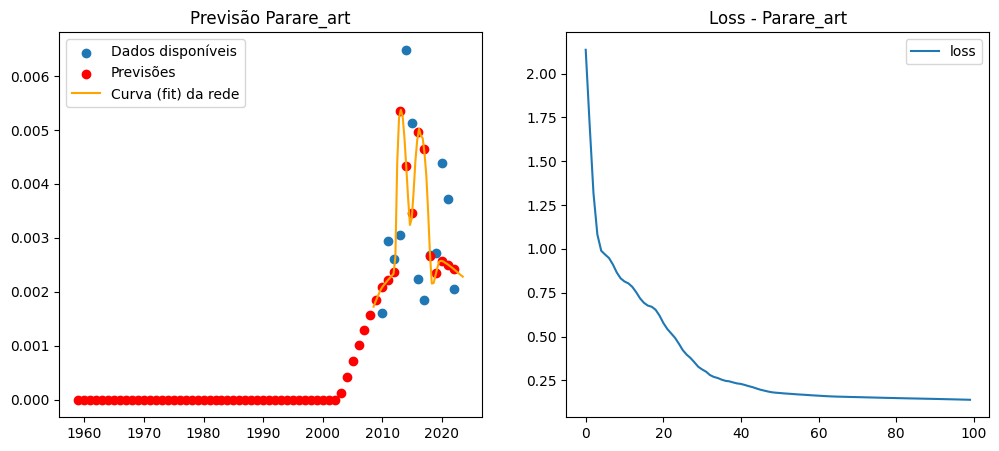

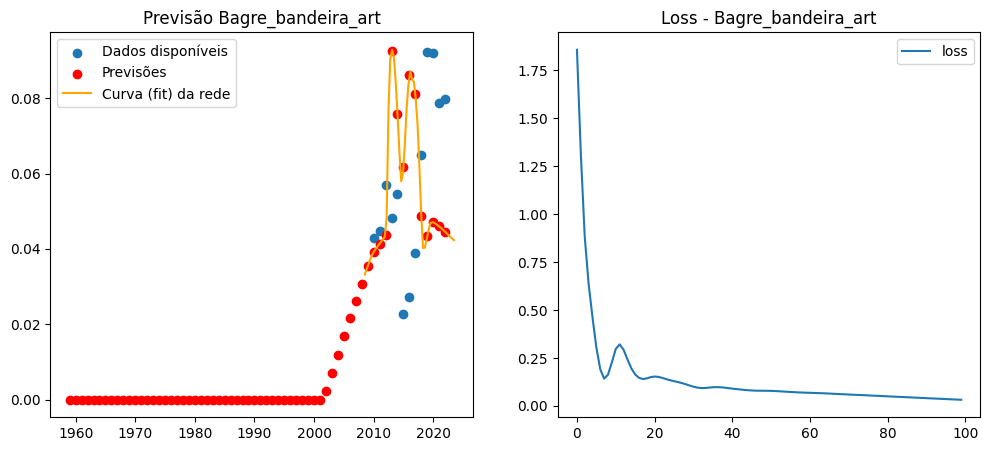

In [13]:
for k, esp in enumerate(especies):
    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.scatter(anos_com_dados, lista_de_prop[k], label='Dados disponíveis')
    plt.scatter(anos_para_prever, lista_de_previsoes[k], color='red', label='Previsões')
    plt.plot(p*ano_std + ano_mean, lista_fits[k], color='orange', label='Curva (fit) da rede')
    plt.title(f'Previsão {esp}')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(lista_de_loss[k], label='loss')
    plt.title(f'Loss - {esp}')
    plt.legend()
    
    plt.show()

In [14]:
# PREVISÃO “CONTÍNUA”
ano_inicial = min(anos_para_prever)
ano_final   = max(anos_para_prever)

anos = np.arange(ano_inicial, ano_final+1)
anos_norm = (anos - ano_mean)/ano_std

lista_prev_continua = []
for k, esp in enumerate(especies):
    model.load_weights(f'C:/Users/Meu Computador/Documents/Tubaroes/pesos_prop_Bagre_art/.weights.h5')
    prev = model.predict(anos_norm)
    prev = prev * lista_prop_std[k] + lista_prop_mean[k]
    
    prev[prev < 0] = 0
    prev[prev > 1] = 1
    
    lista_prev_continua.append(prev.flatten())


2/2 [==============================] - 0s 999us/step


In [15]:
# Forçando soma = 1
prop_soma = np.zeros(len(anos))
for arr in lista_prev_continua:
    prop_soma += arr
prop_soma[prop_soma == 0] = 1e-9

for k in range(len(especies)):
    lista_prev_continua[k] /= prop_soma
    print(lista_prev_continua[1])

[0.27622414 0.28777272 0.29932123 0.3108697  0.3224182  0.33396667
 0.34549087 0.35700786 0.3685252  0.38004255 0.39155978 0.403077
 0.41459432 0.42611155 0.4376287  0.449146   0.46066335 0.47218058
 0.4836978  0.495215   0.5067322  0.5182495  0.52976674 0.54128397
 0.5528013  0.5643184  0.57583493 0.5873488  0.59886277 0.61037654
 0.62189054 0.6334045  0.6449183  0.6564322  0.66794616 0.67946005
 0.690974   0.7024878  0.7140018  0.7255156  0.73702955 0.7485435
 0.76005745 0.7715713  0.7830853  0.7945942  0.80611825 0.8176227
 0.82884365 0.83987623 0.85082424 0.8599999  0.8653108  0.87062
 0.9880164  0.9480445  0.91400564 0.9730397  0.9604858  0.8828317
 0.87004316 0.87886035 0.876256   0.87288463]
[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         

In [12]:
df_prev = pd.DataFrame({
    'Ano': anos,
    especies[0]: lista_prev_continua[0],
    especies[1]: lista_prev_continua[1],
    especies[2]: lista_prev_continua[2],
    especies[3]: lista_prev_continua[3]
})

     Ano  Bagre_art  Bagre_amarelo_art_prop  Bagre_branco_art_prop  \
0   1950        NaN                     NaN                    NaN   
1   1951        NaN                     NaN                    NaN   
2   1952        NaN                     NaN                    NaN   
3   1953        NaN                     NaN                    NaN   
4   1954        NaN                     NaN                    NaN   
5   1955        NaN                     NaN                    NaN   
6   1956        NaN                     NaN                    NaN   
7   1957        NaN                     NaN                    NaN   
8   1958        NaN                     NaN                    NaN   
9   1959     112.00                     NaN                    NaN   
10  1960      65.00                     NaN                    NaN   
11  1961     102.93                     NaN                    NaN   
12  1962        NaN                     NaN                    NaN   
13  1963      83.50 